# g1-4_v047
rel_predでのspeed0処理

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
import scipy.interpolate
import scipy.sparse

In [2]:
area_labeling = pd.read_csv('../output/prep/area_labeling/result.csv')

g1 = list(area_labeling[area_labeling['g']==1]['collectionName'])
g2 = list(area_labeling[area_labeling['g']==2]['collectionName'])
g3 = list(area_labeling[area_labeling['g']==3]['collectionName'])
g4 = list(area_labeling[area_labeling['g']==4]['collectionName'])
g5 = list(area_labeling[area_labeling['g']==5]['collectionName'])

In [3]:
target = g1 + g2 + g3 + g4

In [4]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = g3 + g4

In [5]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [6]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [7]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [8]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [9]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [10]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [11]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [12]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [13]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [14]:
def update_baseline(df, rb):
    rb = rb.rename(columns={'latDeg':'latDeg_rb', 'lngDeg':'lngDeg_rb'})
    df = df.merge(rb[['millisSinceGpsEpoch', 'phone', 'latDeg_rb', 'lngDeg_rb']], on=['millisSinceGpsEpoch', 'phone'], how='left')

    idx = df[~df['latDeg_rb'].isnull()].index
    df.loc[idx, 'latDeg'] = df.loc[idx, 'latDeg_rb']
    df.loc[idx, 'lngDeg'] = df.loc[idx, 'lngDeg_rb']
    
    df.drop(columns=['latDeg_rb', 'lngDeg_rb'], inplace=True)
    
    return df

# 自前再構成baselineに更新

In [15]:
train, test, sub, gt = get_data()
train = train[train['collectionName'].isin(target)].copy()

In [16]:
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g1_v001/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g2_v003/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g3_v003/result.csv'))
train = update_baseline(train, pd.read_csv('../output/prep/baseline_g4_v002/result.csv'))

# ML結果を結合

In [17]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv', usecols=['phone', 'millisSinceGpsEpoch', 'isSpeed0'])
train = train.merge(train_sp0_pred, on=['phone', 'millisSinceGpsEpoch'], how='left')

dp_train = pd.read_csv('../output/prep/rel_pred_v002/train_result.csv')
train = train.merge(dp_train[['millisSinceGpsEpoch', 'phone', 'lat_diff', 'lng_diff']], on=['millisSinceGpsEpoch', 'phone'], how='left')
train.loc[train['isSpeed0']==1, ['lat_diff', 'lng_diff']] = 0

# 相対移動距離をもとにした外れ値除去

In [18]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [19]:
def interpolate_remove_point(df):
    out_df = pd.DataFrame()
    collections = df['collectionName'].unique()
    
    for collection in collections:
        tmp = df[df['collectionName']==collection].copy()
        tmp = tmp.sort_values('millisSinceGpsEpoch')
        tmp = tmp.reset_index().set_index('millisSinceGpsEpoch')
        tmp[['latDeg', 'lngDeg']] = tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        tmp = tmp.sort_values('index')
        tmp = tmp.reset_index().set_index('index')
        out_df = out_df.append(tmp)
    return out_df

In [20]:
# reject outlier
train = add_distance_diff(train)
train.loc[((train['dist_prev'] > ro_th) & (train['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan
train = interpolate_remove_point(train)

# 相対座標をもとにした外れ値除去

In [21]:
def make_th_data(df):
    def quantile_mean(s):
        lth, uth = np.percentile(s, [5, 95]) 
        return s[(s>lth) & (s<uth)].mean()
    def quantile_std(s):
        lth, uth = np.percentile(s, [5, 95]) 
        return s[(s>lth) & (s<uth)].std()
    
    window = 60
    sigma = 2
    output_df = pd.DataFrame()
    
    df = df.sort_values('millisSinceGpsEpoch').reset_index(drop=True)
    for idx in df.index:
        tmp = df[idx : idx + window].copy()
        if not np.isnan(tmp.at[idx, 'latDeg']):        
            tmp['lat_base'] = tmp['lat_diff'].shift(1)
            tmp['lng_base'] = tmp['lng_diff'].shift(1)
            tmp.loc[idx, 'lat_base'] = tmp.loc[idx, 'latDeg']
            tmp.loc[idx, 'lng_base'] = tmp.loc[idx, 'lngDeg']
            tmp['lat_base'] = tmp['lat_base'].cumsum()
            tmp['lng_base'] = tmp['lng_base'].cumsum()
            output_df = output_df.append(tmp[['phone', 'millisSinceGpsEpoch', 'lat_base', 'lng_base']])

    df = df.sort_values('millisSinceGpsEpoch', ascending=False).reset_index(drop=True)
    for idx in df.index:
        tmp = df[idx : idx + window].copy()
        if not np.isnan(tmp.at[idx, 'latDeg']):        
            tmp['lat_base'] = -tmp['lat_diff']
            tmp['lng_base'] = -tmp['lng_diff']
            tmp.loc[idx, 'lat_base'] = tmp.loc[idx, 'latDeg']
            tmp.loc[idx, 'lng_base'] = tmp.loc[idx, 'lngDeg']
            tmp['lat_base'] = tmp['lat_base'].cumsum()
            tmp['lng_base'] = tmp['lng_base'].cumsum()
            output_df = output_df.append(tmp[['phone', 'millisSinceGpsEpoch', 'lat_base', 'lng_base']])
    
    output_df = output_df.groupby(['phone','millisSinceGpsEpoch']).agg({'lat_base':[quantile_mean, quantile_std], 'lng_base':[quantile_mean, quantile_std]}).reset_index()
    output_df.columns = ['phone', 'millisSinceGpsEpoch', 'lat_base_mean', 'lat_base_std', 'lng_base_mean', 'lng_base_std']

    output_df['lat_uth'] = output_df['lat_base_mean'] + (output_df['lat_base_std'] * sigma)
    output_df['lat_lth'] = output_df['lat_base_mean'] - (output_df['lat_base_std'] * sigma)
    output_df['lng_uth'] = output_df['lng_base_mean'] + (output_df['lng_base_std'] * sigma)
    output_df['lng_lth'] = output_df['lng_base_mean'] - (output_df['lng_base_std'] * sigma)

    return output_df[['millisSinceGpsEpoch', 'lat_uth', 'lat_lth', 'lng_uth' , 'lng_lth']]

In [22]:
def reject_outlier_by_base_trajectory(df):
    output_df = pd.DataFrame()
    for phone in df['phone'].unique():            
        tmp = df[df['phone']==phone].copy()
        phonename = phone.split('_')[1]
        if phonename != 'Mi8':
            th_data = make_th_data(tmp)
            tmp = tmp.merge(th_data, on=['millisSinceGpsEpoch'], how='left')
            reject_idx = tmp[(tmp['latDeg']>tmp['lat_uth']) | (tmp['latDeg']<tmp['lat_lth']) | (tmp['lngDeg']>tmp['lng_uth']) | (tmp['lngDeg']<tmp['lng_lth'])].index
            tmp.loc[reject_idx, 'latDeg'] = np.nan
            tmp.loc[reject_idx, 'lngDeg'] = np.nan
            print(phone, len(reject_idx))
        output_df = output_df.append(tmp)
        
    return output_df.reset_index(drop=True)

In [23]:
train = reject_outlier_by_base_trajectory(train)

2020-05-14-US-MTV-1_Pixel4 120
2020-05-14-US-MTV-1_Pixel4XLModded 148
2020-05-14-US-MTV-2_Pixel4 80
2020-05-14-US-MTV-2_Pixel4XLModded 57
2020-05-21-US-MTV-1_Pixel4 153
2020-05-21-US-MTV-2_Pixel4 104
2020-05-21-US-MTV-2_Pixel4XL 133
2020-05-29-US-MTV-1_Pixel4 126
2020-05-29-US-MTV-1_Pixel4XL 98
2020-05-29-US-MTV-1_Pixel4XLModded 118
2020-05-29-US-MTV-2_Pixel4 131
2020-05-29-US-MTV-2_Pixel4XL 150
2020-06-04-US-MTV-1_Pixel4 113
2020-06-04-US-MTV-1_Pixel4XL 116
2020-06-04-US-MTV-1_Pixel4XLModded 127
2020-06-05-US-MTV-1_Pixel4 235
2020-06-05-US-MTV-1_Pixel4XL 202
2020-06-05-US-MTV-1_Pixel4XLModded 126
2020-06-05-US-MTV-2_Pixel4 117
2020-06-05-US-MTV-2_Pixel4XL 129
2020-06-11-US-MTV-1_Pixel4 138
2020-06-11-US-MTV-1_Pixel4XL 105
2020-07-08-US-MTV-1_Pixel4 197
2020-07-08-US-MTV-1_Pixel4XL 103
2020-07-08-US-MTV-1_Pixel4XLModded 117
2020-08-03-US-MTV-1_Pixel4 168
2020-08-06-US-MTV-2_Pixel4 125
2020-08-06-US-MTV-2_Pixel4XL 91
2020-09-04-US-SF-1_Pixel4 199
2020-09-04-US-SF-1_Pixel4XL 101
2020-09-

# ground_truthを基準にした外れ値除去

In [24]:
def get_osmnx_data():
    p = pathlib.Path(INPUT)
    files = list(p.glob('prep/osmnx/*.csv'))

    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    osmnx = pd.concat(dfs)

    return osmnx

In [25]:
def remove_based_on_gt(target_df, target_gt, th):
    osmnx_data = get_osmnx_data()
    target_gt = target_gt.append(osmnx_data)
    
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        collection = target_df.at[idx, 'collectionName']
        
        if collection in ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']:
            th = 3
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

In [26]:
rog_df = train[train['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

In [27]:
train = interpolate_remove_point(train)

# kalmanフィルタ

In [28]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [29]:
train = apply_kf_smoothing(train)
train.to_csv(OUTPUT + '/train_ro_rog_kf.csv', index=False)

# speed0の処理

In [23]:
def sp0_rel_process(df):
    def quantile_mean(s):
        lth, uth = np.percentile(s, [5, 95]) 
        return s[(s>lth) & (s<uth)].mean()
    
    window = 60
    add_data = pd.DataFrame()
    output_df = pd.DataFrame()
    
    df = df.sort_values('millisSinceGpsEpoch').reset_index(drop=True)
    for idx in df.index:
        tmp = df[idx : idx + window].copy()
        if not np.isnan(tmp.at[idx, 'latDeg']):
            if tmp.at[idx, 'isSpeed0'] == 0:
                tmp['lat_new'] = tmp['lat_diff'].shift(1)
                tmp['lng_new'] = tmp['lng_diff'].shift(1)
                tmp.loc[idx, 'lat_new'] = tmp.loc[idx, 'latDeg']
                tmp.loc[idx, 'lng_new'] = tmp.loc[idx, 'lngDeg']
                tmp['lat_new'] = tmp['lat_new'].cumsum()
                tmp['lng_new'] = tmp['lng_new'].cumsum()
                tmp = tmp[tmp['isSpeed0']==1].copy()
                add_data = add_data.append(tmp)

    df = df.sort_values('millisSinceGpsEpoch', ascending=False).reset_index(drop=True)
    for idx in df.index:
        tmp = df[idx : idx + window].copy()
        if not np.isnan(tmp.at[idx, 'latDeg']):
            if tmp.at[idx, 'isSpeed0'] == 0:
                tmp['lat_new'] = -tmp['lat_diff']
                tmp['lng_new'] = -tmp['lng_diff']
                tmp.loc[idx, 'lat_new'] = tmp.loc[idx, 'latDeg']
                tmp.loc[idx, 'lng_new'] = tmp.loc[idx, 'lngDeg']
                tmp['lat_new'] = tmp['lat_new'].cumsum()
                tmp['lng_new'] = tmp['lng_new'].cumsum()
                tmp = tmp[tmp['isSpeed0']==1].copy()
                add_data = add_data.append(tmp)
                
    return add_data
    
    output_df = output_df.groupby(['phone','millisSinceGpsEpoch']).agg({'lat_base':[quantile_mean, quantile_std], 'lng_base':[quantile_mean, quantile_std]}).reset_index()
    output_df.columns = ['phone', 'millisSinceGpsEpoch', 'lat_base_mean', 'lat_base_std', 'lng_base_mean', 'lng_base_std']

    output_df['lat_uth'] = output_df['lat_base_mean'] + (output_df['lat_base_std'] * sigma)
    output_df['lat_lth'] = output_df['lat_base_mean'] - (output_df['lat_base_std'] * sigma)
    output_df['lng_uth'] = output_df['lng_base_mean'] + (output_df['lng_base_std'] * sigma)
    output_df['lng_lth'] = output_df['lng_base_mean'] - (output_df['lng_base_std'] * sigma)

    return output_df[['millisSinceGpsEpoch', 'lat_uth', 'lat_lth', 'lng_uth' , 'lng_lth']]

In [28]:
df = train[train['phone']=='2020-05-14-US-MTV-1_Pixel4'].copy()

In [29]:
df['group'] = df.groupby('phone').cumcount()
df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
df['group'] = df['group'].fillna(method='ffill')
df

collectionName phoneName  millisSinceGpsEpoch     latDeg  \
0     2020-05-14-US-MTV-1    Pixel4        1273529463442  37.423556   
1     2020-05-14-US-MTV-1    Pixel4        1273529464442  37.423553   
2     2020-05-14-US-MTV-1    Pixel4        1273529465442  37.423558   
3     2020-05-14-US-MTV-1    Pixel4        1273529466442  37.423556   
4     2020-05-14-US-MTV-1    Pixel4        1273529467442  37.423550   
...                   ...       ...                  ...        ...   
1735  2020-05-14-US-MTV-1    Pixel4        1273531198442  37.645814   
1736  2020-05-14-US-MTV-1    Pixel4        1273531199442  37.645813   
1737  2020-05-14-US-MTV-1    Pixel4        1273531200442  37.645809   
1738  2020-05-14-US-MTV-1    Pixel4        1273531201442  37.645812   
1739  2020-05-14-US-MTV-1    Pixel4        1273531202442  37.645810   

          lngDeg  heightAboveWgs84EllipsoidM                       phone  \
0    -122.094075                      -34.06  2020-05-14-US-MTV-1_Pixel4   
1    -122.094085                      -33.29  2020-05-14-US-MTV-1_Pixel4   
2    -122.094100                      -30.99  2020-05-14-US-MTV-1_Pixel4   
3    -122.094097                      -32.83  2020-05-14-US-MTV-1_Pixel4   
4    -122.094111                      -34.49  2020-05-14-US-MTV-1_Pixel4   
...          ...                         ...                         ...   
1735 -122.405602                      -33.66  2020-05-14-US-MTV-1_Pixel4   
1736 -122.405595                      -34.77  2020-05-14-US-MTV-1_Pixel4   
1737 -122.405592                      -35.89  2020-05-14-US-MTV-1_Pixel4   
1738 -122.405608                      -35.07  2020-05-14-US-MTV-1_Pixel4   
1739 -122.405611                      -33.94  2020-05-14-US-MTV-1_Pixel4   

      isSpeed0  lat_diff  lng_diff   group  
0            1       0.0       0.0     0.0  
1            1       0.0       0.0     0.0  
2            1       0.0       0.0     0.0  
3            1       0.0       0.0     0.0  
4            1       0.0       0.0     0.0  
...        ...       ...       ...     ...  
1735         1       0.0       0.0  1703.0  
1736         1       0.0       0.0  1703.0  
1737         1       0.0       0.0  1703.0  
1738         1       0.0       0.0  1703.0  
1739         1       0.0       0.0  1703.0  

[1740 rows x 11 columns]

In [30]:
df2 = sp0_rel_process(df)
df2

collectionName phoneName  millisSinceGpsEpoch     latDeg  \
1704  2020-05-14-US-MTV-1    Pixel4        1273531167442  37.645817   
1704  2020-05-14-US-MTV-1    Pixel4        1273531167442  37.645817   
1705  2020-05-14-US-MTV-1    Pixel4        1273531168442  37.645821   
1704  2020-05-14-US-MTV-1    Pixel4        1273531167442  37.645817   
1705  2020-05-14-US-MTV-1    Pixel4        1273531168442  37.645821   
...                   ...       ...                  ...        ...   
1729  2020-05-14-US-MTV-1    Pixel4        1273529473442  37.423573   
1730  2020-05-14-US-MTV-1    Pixel4        1273529472442  37.423573   
1731  2020-05-14-US-MTV-1    Pixel4        1273529471442  37.423568   
1732  2020-05-14-US-MTV-1    Pixel4        1273529470442  37.423557   
1733  2020-05-14-US-MTV-1    Pixel4        1273529469442  37.423564   

          lngDeg  heightAboveWgs84EllipsoidM                       phone  \
1704 -122.405595                      -33.14  2020-05-14-US-MTV-1_Pixel4   
1704 -122.405595                      -33.14  2020-05-14-US-MTV-1_Pixel4   
1705 -122.405598                      -32.65  2020-05-14-US-MTV-1_Pixel4   
1704 -122.405595                      -33.14  2020-05-14-US-MTV-1_Pixel4   
1705 -122.405598                      -32.65  2020-05-14-US-MTV-1_Pixel4   
...          ...                         ...                         ...   
1729 -122.094127                      -33.84  2020-05-14-US-MTV-1_Pixel4   
1730 -122.094122                      -34.76  2020-05-14-US-MTV-1_Pixel4   
1731 -122.094117                      -34.22  2020-05-14-US-MTV-1_Pixel4   
1732 -122.094112                      -31.60  2020-05-14-US-MTV-1_Pixel4   
1733 -122.094113                      -33.52  2020-05-14-US-MTV-1_Pixel4   

      isSpeed0  lat_diff  lng_diff   group    lat_new     lng_new  
1704         1       0.0       0.0  1703.0  37.645830 -122.405605  
1704         1       0.0       0.0  1703.0  37.645837 -122.405600  
1705         1       0.0       0.0  1703.0  37.645837 -122.405600  
1704         1       0.0       0.0  1703.0  37.645833 -122.405606  
1705         1       0.0       0.0  1703.0  37.645833 -122.405606  
...        ...       ...       ...     ...        ...         ...  
1729         1       0.0       0.0     0.0  37.423590 -122.094123  
1730         1       0.0       0.0     0.0  37.423590 -122.094123  
1731         1       0.0       0.0     0.0  37.423590 -122.094123  
1732         1       0.0       0.0     0.0  37.423590 -122.094123  
1733         1       0.0       0.0     0.0  37.423590 -122.094123  

[3264 rows x 13 columns]

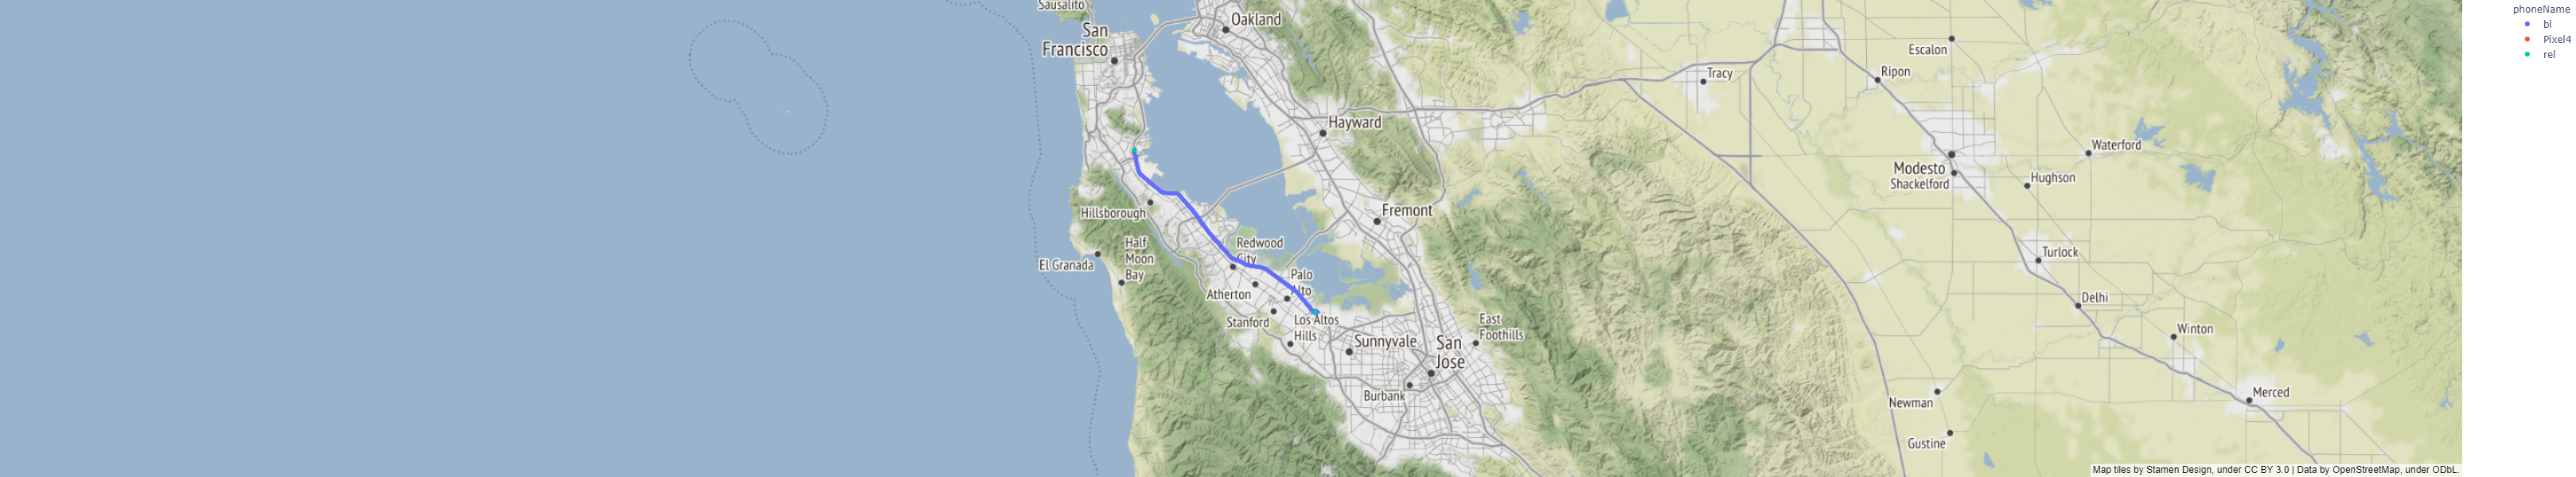

In [37]:
tmp1 = gt[(gt['collectionName']=='2020-05-14-US-MTV-1')&(gt['phoneName']=='Pixel4')].copy()
tmp1['phoneName'] = 'gt'
tmp2 = df2[['collectionName', 'phoneName', 'latDeg', 'lngDeg']].copy()
tmp1['phoneName'] = 'bl'
tmp3 = df2[['collectionName', 'phoneName', 'lat_new', 'lng_new']].copy()
tmp3.columns = ['collectionName', 'phoneName', 'latDeg', 'lngDeg']
tmp3['phoneName'] = 'rel'
tmp = pd.concat([tmp1, tmp2, tmp3])
visualize_collection(tmp, '2020-05-14-US-MTV-1')

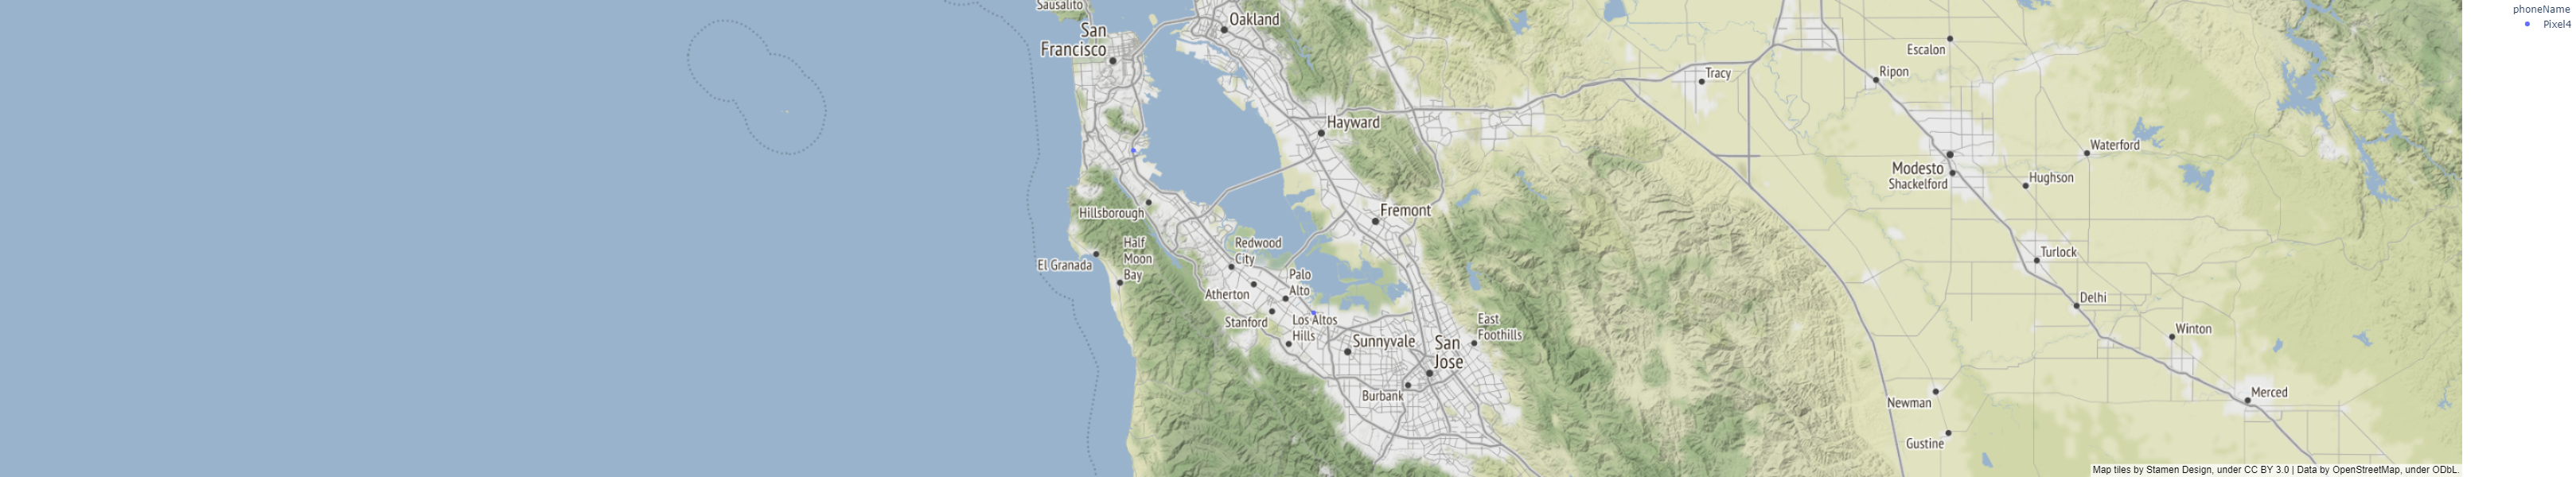

In [31]:
df2.to_csv('check.csv')

In [30]:
def sp0_process(df):
    output_df = pd.DataFrame()
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    
    for phone in df['phone'].unique():
        tmp = df[df['phone']==phone].copy()
        phonename = phone.split('_')[1]
        if phonename == 'Mi8':
            tmp[['latDeg', 'lngDeg']] = tmp.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
        else:
            tmp = sp0_rel_process(tmp)
        output_df = output_df.append(tmp)
            
    return output_df

In [31]:
train = sp0_process(train)

# cost_minimization

In [32]:
def cost_minimization(df, b):
    xy_hat = df[['latDeg', 'lngDeg']].to_numpy()
    delta_xy_hat = df[['lat_diff', 'lng_diff']].fillna(method='ffill')[:-1].to_numpy()

    N = xy_hat.shape[0]
    alpha = 0.01 * np.ones(N)
    beta  = b * np.ones(N-1)

    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags(beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return xy_star

In [33]:
def cost_min_objective(trial):
    cost_min_beta_g1 = trial.suggest_uniform('cost_min_beta_g1', 0.01, 0.5)
    cost_min_beta_g2 = trial.suggest_uniform('cost_min_beta_g2', 0.01, 0.5)
    cost_min_beta_g3 = trial.suggest_uniform('cost_min_beta_g3', 0.01, 0.5)
    cost_min_beta_g4 = trial.suggest_uniform('cost_min_beta_g4', 0.01, 0.5)
    train_ = train.copy()
    
    for g, w in zip([g1,g2,g3,g4],[cost_min_beta_g1, cost_min_beta_g2, cost_min_beta_g3, cost_min_beta_g4]):
        phones = train[(train['collectionName'].isin(g))&(train['phoneName']!='Mi8')]['phone'].unique()
        for phone in phones:
            idx = train[train['phone']==phone].index
            train_.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(train_.loc[idx], w)
    score = train_result(train_[train_['collectionName'].isin(target)]).score
    return score

In [34]:
study = optuna.create_study()
study.optimize(cost_min_objective, n_trials=100)
print(study.best_params)

cost_min_beta_g1 = study.best_params['cost_min_beta_g1']
cost_min_beta_g2 = study.best_params['cost_min_beta_g2']
cost_min_beta_g3 = study.best_params['cost_min_beta_g3']
cost_min_beta_g4 = study.best_params['cost_min_beta_g4']

[I 2021-08-03 20:12:58,983] A new study created in memory with name: no-name-de6dcb04-6e2f-4c6d-89cf-17da9de2a8da
[I 2021-08-03 20:13:00,285] Trial 0 finished with value: 2.587336171732538 and parameters: {'cost_min_beta_g1': 0.07923923441892511, 'cost_min_beta_g2': 0.03646867757411962, 'cost_min_beta_g3': 0.25447786072891687, 'cost_min_beta_g4': 0.19695078089070023}. Best is trial 0 with value: 2.587336171732538.
[I 2021-08-03 20:13:01,671] Trial 1 finished with value: 2.629324306086874 and parameters: {'cost_min_beta_g1': 0.21769183726190142, 'cost_min_beta_g2': 0.49009180242700073, 'cost_min_beta_g3': 0.03442629011448684, 'cost_min_beta_g4': 0.3298384693522207}. Best is trial 0 with value: 2.587336171732538.
[I 2021-08-03 20:13:02,907] Trial 2 finished with value: 2.574517757197397 and parameters: {'cost_min_beta_g1': 0.06554790686919247, 'cost_min_beta_g2': 0.3844361697282609, 'cost_min_beta_g3': 0.3166374671455463, 'cost_min_beta_g4': 0.4443464367258403}. Best is trial 2 with valu

{'cost_min_beta_g1': 0.05601052165502048, 'cost_min_beta_g2': 0.3104120687413948, 'cost_min_beta_g3': 0.43130374317168235, 'cost_min_beta_g4': 0.40374704826806734}


In [35]:
for g, w in zip([g1,g2,g3,g4],[cost_min_beta_g1, cost_min_beta_g2, cost_min_beta_g3, cost_min_beta_g4]):
    phones = train[(train['collectionName'].isin(g))&(train['phoneName']!='Mi8')]['phone'].unique()
    for phone in phones:
        idx = train[train['phone']==phone].index
        train.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(train.loc[idx], w)
print(train_result(train[train['collectionName'].isin(target)]).score)

2.5713904274643036


# phones_weighted_mean

In [36]:
train_ = train[train['collectionName'].isin(target)].copy()

In [37]:
def calc_mean_pred(df, ws):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list = df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    tmp['phone'] = tmp['collectionName'] + '_' + tmp['phoneName']
    tmp = tmp.merge(df, on=['collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch'], how='left')
    
    lerp_df = pd.DataFrame()
    for phone in tmp['phone'].unique():
        lerp_tmp = tmp[tmp['phone']==phone].copy()
        lerp_tmp = lerp_tmp.sort_values('millisSinceGpsEpoch')
        lerp_tmp = lerp_tmp.set_index('millisSinceGpsEpoch')
        lerp_tmp[['latDeg', 'lngDeg']] = lerp_tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        lerp_tmp = lerp_tmp.reset_index()
        lerp_df = lerp_df.append(lerp_tmp)
    
    lerp_df['w'] = lerp_df['phoneName'].replace(ws)
    lerp_df.loc[lerp_df['latDeg'].isnull(), 'w'] = np.nan
    lerp_df['w_sum'] = lerp_df.groupby(['collectionName', 'millisSinceGpsEpoch'])['w'].transform('sum')
    lerp_df['w'] = lerp_df['w'] / lerp_df['w_sum']
    lerp_df['latDeg'] = lerp_df['latDeg'] * lerp_df['w']
    lerp_df['lngDeg'] = lerp_df['lngDeg'] * lerp_df['w']
    mean_pred = lerp_df.groupby(['collectionName', 'millisSinceGpsEpoch'])['latDeg', 'lngDeg'].sum().reset_index()
    
    output_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    output_df = output_df.merge(mean_pred[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return output_df

In [38]:
def phones_mean_objective(trial):
    Pixel4 = trial.suggest_int('Pixel4', 1, 10)
    Pixel4XLModded = trial.suggest_int('Pixel4XLModded', 1, 10)
    Pixel4XL = trial.suggest_int('Pixel4XL', 1, 10)
    Mi8 = trial.suggest_int('Mi8', 1, 10)
    Pixel4Modded = trial.suggest_int('Pixel4Modded', 1, 10)
    Pixel5 = trial.suggest_int('Pixel5', 1, 10)
    SamsungS20Ultra = trial.suggest_int('SamsungS20Ultra', 1, 10)
    
    ws = {'Pixel4':Pixel4, 'Pixel4XLModded':Pixel4XLModded, 'Pixel4XL':Pixel4XL, 'Mi8':Mi8, 'Pixel4Modded':Pixel4Modded,
          'Pixel5':Pixel5, 'SamsungS20Ultra':SamsungS20Ultra}
    
    out = calc_mean_pred(train_, ws)
    score = train_result(out).score
    
    return score

In [39]:
study = optuna.create_study()
study.optimize(phones_mean_objective, n_trials=100)
phones_mean_weights = study.best_params
print(phones_mean_weights)

[I 2021-08-03 20:15:12,670] A new study created in memory with name: no-name-7146b894-41be-4309-8204-96f215eb5d2e
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
[I 2021-08-03 20:15:18,489] Trial 0 finished with value: 2.2090207922895004 and parameters: {'Pixel4': 8, 'Pixel4XLModded': 4, 'Pixel4XL': 6, 'Mi8': 9, 'Pixel4Modded': 5, 'Pixel5': 9, 'SamsungS20Ultra': 4}. Best is trial 0 with value: 2.2090207922895004.
[I 2021-08-03 20:15:24,351] Trial 1 finished with value: 2.3215997225236578 and parameters: {'Pixel4': 3, 'Pixel4XLModded': 8, 'Pixel4XL': 1, 'Mi8': 8, 'Pixel4Modded': 3, 'Pixel5': 10, 'SamsungS20Ultra': 2}. Best is trial 0 with value: 2.2090207922895004.
[I 2021-08-03 20:15:30,303] Trial 2 finished with value: 2.226867812654689 and parameters: {'Pixel4': 6, 'Pixel4XLModded': 3, 'Pixel4XL': 8, 'Mi8': 7, 'Pixel4Modded': 3, 'Pixel5': 8, 'S

{'Pixel4': 3, 'Pixel4XLModded': 2, 'Pixel4XL': 2, 'Mi8': 2, 'Pixel4Modded': 8, 'Pixel5': 4, 'SamsungS20Ultra': 1}


In [40]:
train = calc_mean_pred(train, phones_mean_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


# position_shift

In [41]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']

In [42]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [43]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [44]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-08-03 20:27:24,600] A new study created in memory with name: no-name-5036e8da-87a5-4186-a8e4-9cef7b6effa6
[I 2021-08-03 20:27:29,087] Trial 0 finished with value: 2.4479253639466476 and parameters: {'a': -0.715545058720743}. Best is trial 0 with value: 2.4479253639466476.
[I 2021-08-03 20:27:33,409] Trial 1 finished with value: 2.256046659506576 and parameters: {'a': -0.36563966887586186}. Best is trial 1 with value: 2.256046659506576.
[I 2021-08-03 20:27:37,895] Trial 2 finished with value: 2.1079970721797103 and parameters: {'a': 0.49947294217661664}. Best is trial 2 with value: 2.1079970721797103.
[I 2021-08-03 20:27:42,571] Trial 3 finished with value: 2.4421657941807298 and parameters: {'a': -0.7065094633575861}. Best is trial 2 with value: 2.1079970721797103.
[I 2021-08-03 20:27:47,600] Trial 4 finished with value: 2.2224824744720477 and parameters: {'a': -0.2833427014180654}. Best is trial 2 with value: 2.1079970721797103.
[I 2021-08-03 20:27:52,408] Trial 5 finished wit

0.35514988127463315


In [45]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rog_kf_sp0_pm_ps.csv', index=False)

In [46]:
train = train[train['collectionName'].isin(target)].copy()

# trainの結果確認

In [47]:
result = train_result(train)

In [48]:
result.score

2.1010448529475054

In [49]:
result.err

percentile50  percentile95  p50_p90_mean
phone                                                                        
2020-05-14-US-MTV-1_Pixel4               1.049598      1.930156      1.489877
2020-05-14-US-MTV-1_Pixel4XLModded       0.968049      1.835652      1.401851
2020-05-14-US-MTV-2_Pixel4               1.799122      2.583508      2.191315
2020-05-14-US-MTV-2_Pixel4XLModded       1.755462      2.853909      2.304685
2020-05-21-US-MTV-1_Pixel4               1.953191      3.616279      2.784735
2020-05-21-US-MTV-2_Pixel4               0.628295      1.973055      1.300675
2020-05-21-US-MTV-2_Pixel4XL             0.580768      1.936618      1.258693
2020-05-29-US-MTV-1_Pixel4               1.726346      2.585113      2.155730
2020-05-29-US-MTV-1_Pixel4XL             1.708389      2.575766      2.142078
2020-05-29-US-MTV-1_Pixel4XLModded       1.711571      2.587238      2.149404
2020-05-29-US-MTV-2_Pixel4               2.284331      3.529526      2.906928
2020-05-29-US-MTV-2_Pixel4XL             2.215478      3.554233      2.884856
2020-06-04-US-MTV-1_Pixel4               0.881971      1.862438      1.372204
2020-06-04-US-MTV-1_Pixel4XL             0.954088      1.906266      1.430177
2020-06-04-US-MTV-1_Pixel4XLModded       0.951263      2.323451      1.637357
2020-06-05-US-MTV-1_Pixel4               0.819038      2.218644      1.518841
2020-06-05-US-MTV-1_Pixel4XL             0.863768      2.592359      1.728064
2020-06-05-US-MTV-1_Pixel4XLModded       0.788623      3.013306      1.900964
2020-06-05-US-MTV-2_Pixel4               1.025066      2.262916      1.643991
2020-06-05-US-MTV-2_Pixel4XL             0.966971      2.183130      1.575051
2020-06-11-US-MTV-1_Pixel4               0.729206      1.743415      1.236310
2020-06-11-US-MTV-1_Pixel4XL             0.743628      1.822523      1.283075
2020-07-08-US-MTV-1_Pixel4               0.794998      1.831276      1.313137
2020-07-08-US-MTV-1_Pixel4XL             0.804807      1.681471      1.243139
2020-07-08-US-MTV-1_Pixel4XLModded       0.673463      1.517259      1.095361
2020-07-17-US-MTV-1_Mi8                  1.803597      3.465797      2.634697
2020-07-17-US-MTV-2_Mi8                  2.818596      4.166983      3.492789
2020-08-03-US-MTV-1_Mi8                  1.540254      2.393120      1.966687
2020-08-03-US-MTV-1_Pixel4               1.666076      2.558205      2.112140
2020-08-06-US-MTV-2_Mi8                  0.775357      1.934803      1.355080
2020-08-06-US-MTV-2_Pixel4               0.800232      1.941160      1.370696
2020-08-06-US-MTV-2_Pixel4XL             0.807339      1.982385      1.394862
2020-09-04-US-SF-1_Mi8                   1.025094      2.902119      1.963607
2020-09-04-US-SF-1_Pixel4                1.076463      3.339503      2.207983
2020-09-04-US-SF-1_Pixel4XL              1.037992      3.057943      2.047967
2020-09-04-US-SF-2_Mi8                   1.053092      4.476095      2.764593
2020-09-04-US-SF-2_Pixel4                0.838997      3.425756      2.132377
2020-09-04-US-SF-2_Pixel4XL              0.830824      3.446139      2.138481
2021-01-04-US-RWC-1_Pixel4               0.796663      2.026656      1.411659
2021-01-04-US-RWC-1_Pixel4Modded         0.973664      2.257112      1.615388
2021-01-04-US-RWC-1_Pixel4XL             0.817928      2.070818      1.444373
2021-01-04-US-RWC-1_Pixel5               0.816836      2.092523      1.454680
2021-01-04-US-RWC-2_Pixel4               0.996274      2.460700      1.728487
2021-01-04-US-RWC-2_Pixel4Modded         1.131099      2.645417      1.888258
2021-01-04-US-RWC-2_Pixel4XL             1.000890      2.496323      1.748606
2021-01-04-US-RWC-2_Pixel5               1.043233      3.021870      2.032551
2021-01-05-US-SVL-1_Mi8                  1.184996      3.156592      2.170794
2021-01-05-US-SVL-1_Pixel4               1.374040      3.394236      2.384138
2021-01-05-US-SVL-1_Pixel4XL             1.327518      3.320395      2.323956
2021-01-05-US-SVL-1_Pixel5               1.295009      3.22

In [50]:
train.to_csv(OUTPUT + f'/{nb_name}_train.csv', index=False)

# make_sub

In [51]:
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
test = test[test['collectionName'].isin(target)].copy()

In [52]:
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g1_v001/result_test.csv'))
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g2_v003/result_test.csv'))
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g3_v003/result_test.csv'))
test = update_baseline(test, pd.read_csv('../output/prep/baseline_g4_v002/result_test.csv'))

In [53]:
test_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv', usecols=['phone', 'millisSinceGpsEpoch', 'isSpeed0'])
test = test.merge(test_sp0_pred, on=['phone', 'millisSinceGpsEpoch'], how='left')

dp_test = pd.read_csv('../output/prep/rel_pred_v002/test_result.csv')
test = test.merge(dp_test[['millisSinceGpsEpoch', 'phone', 'lat_diff', 'lng_diff']], on=['millisSinceGpsEpoch', 'phone'], how='left')
test.loc[test['isSpeed0']==1, ['lat_diff', 'lng_diff']] = 0

In [54]:
test = add_distance_diff(test)
test.loc[((test['dist_prev'] > ro_th) & (test['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan
test = interpolate_remove_point(test)

In [55]:
test = reject_outlier_by_base_trajectory(test)

2020-05-15-US-MTV-1_Pixel4 671
2020-05-15-US-MTV-1_Pixel4XL 361
2020-05-28-US-MTV-1_Pixel4 183
2020-05-28-US-MTV-1_Pixel4XL 185
2020-05-28-US-MTV-2_Pixel4 196
2020-05-28-US-MTV-2_Pixel4XL 144
2020-05-28-US-MTV-2_Pixel4XLModded 121
2020-06-04-US-MTV-2_Pixel4 61
2020-06-04-US-MTV-2_Pixel4XL 94
2020-06-04-US-MTV-2_Pixel4XLModded 80
2020-06-10-US-MTV-1_Pixel4 108
2020-06-10-US-MTV-1_Pixel4XL 99
2020-06-10-US-MTV-1_Pixel4XLModded 82
2020-06-10-US-MTV-2_Pixel4 71
2020-06-10-US-MTV-2_Pixel4XL 92
2020-06-10-US-MTV-2_Pixel4XLModded 98
2020-08-03-US-MTV-2_Pixel4 108
2020-08-03-US-MTV-2_Pixel4XL 119
2020-08-13-US-MTV-1_Pixel4 257
2021-03-16-US-MTV-2_Pixel4Modded 279
2021-03-16-US-MTV-2_SamsungS20Ultra 170
2021-03-16-US-RWC-2_Pixel4XL 320
2021-03-16-US-RWC-2_Pixel5 288
2021-03-16-US-RWC-2_SamsungS20Ultra 206
2021-03-25-US-PAO-1_Pixel4 178
2021-03-25-US-PAO-1_Pixel4Modded 135
2021-03-25-US-PAO-1_Pixel5 228
2021-03-25-US-PAO-1_SamsungS20Ultra 144
2021-04-02-US-SJC-1_Pixel4 405
2021-04-02-US-SJC-1_Pi

In [56]:
rog_df = test[test['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df.to_csv(OUTPUT + '/test_rog.csv', index=False)
test.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]
test = interpolate_remove_point(test)

In [57]:
test = apply_kf_smoothing(test)

In [58]:
test = sp0_process(test)

In [59]:
for g, w in zip([g1,g2,g3,g4],[cost_min_beta_g1, cost_min_beta_g2, cost_min_beta_g3, cost_min_beta_g4]):
    phones = test[(test['collectionName'].isin(g))&(test['phoneName']!='Mi8')]['phone'].unique()
    for phone in phones:
        idx = test[test['phone']==phone].index
        test.loc[idx, ['latDeg', 'lngDeg']] = cost_minimization(test.loc[idx], w)

In [60]:
test = calc_mean_pred(test, phones_mean_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [61]:
test['phone'] = test['collectionName'] + '_' + test['phoneName']

In [62]:
test = position_shift(test, opt_a)

In [63]:
test = test[test['collectionName'].isin(target)]

In [64]:
test.to_csv(OUTPUT + f'/{nb_name}_test.csv', index=False)